# ENSF 592 Project: Phase II

## Data Preparation

In [1]:
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap

### Get a 10 x 10 matrix of city limits

In [2]:
# Read data for city boundaries
data_city_boundary = pd.read_csv('City_Boundary_layer.csv')

# Manipulate polygon string to get list of coordinates
polygon = data_city_boundary['the_geom'].values[0]
polygon = polygon[10:-2]
coordinates_city_limits = polygon.split(', ')

# Get a list of longitudes and latitudes for the city limits
longitudes_city_limits = []
latitudes_city_limits = []
for long_lat in coordinates_city_limits:
    long, lat = long_lat.split()
    long = float(long)
    lat = float(lat)
    longitudes_city_limits.append(long)
    latitudes_city_limits.append(lat)
    
# Find absolute city limits as the min/max longitude/latitude
overall_min_long = min(longitudes_city_limits)
overall_max_long = max(longitudes_city_limits)
overall_min_lat = min(latitudes_city_limits)
overall_max_lat = max(latitudes_city_limits)

# Split the city into a 10 x 10 matrix
# Create a 10x10 matrix
quadrantdf = pd.DataFrame(columns = ('min_lat', 'max_lat', 'min_long', 'max_long'))
quadrant = [[0 for x in range(10)] for y in range(10)]

# Populate quadrant boundaries
for i in range(0,10):
    # Get the min/max longitude for the quadrant
    min_long = overall_min_long + (overall_max_long - overall_min_long) / 10 * i
    max_long = overall_min_long + (overall_max_long - overall_min_long) / 10 * (i + 1)
    for j in range(0, 10):
        # Get the min/max latitude for the quadrant
        min_lat = overall_min_lat + (overall_max_lat - overall_min_lat) / 10 * j
        max_lat = overall_min_lat + (overall_max_lat - overall_min_lat) / 10 * (j + 1)
        # Populate data into a dataframe for each quadrant
        quadrant[j][i] = {'min_lat':min_lat,'max_lat':max_lat,'min_long':min_long,'max_long':max_long}
        for k in range (0, 100):
            quadrantdf.loc[k] = [min_lat, max_lat, min_long, max_long] #each row represents a grids coordinates
df = pd.DataFrame(quadrant)

### Plot a map of the city limits

In [3]:
# Start maps at the center of Calgary
map_overall_boundaries = folium.Map(location=[51.0447, -114.0719], zoom_start=10)
map_quadrant_boundaries = folium.Map(location=[51.0447, -114.0719], zoom_start=10)

# Place rectangles
# Place rectangle for the overall map
folium.vector_layers.Rectangle([(overall_max_lat, overall_max_long), \
                                (overall_max_lat, overall_min_long), \
                                (overall_min_lat, overall_max_long), \
                                (overall_min_lat, overall_min_long)]).add_to(map_overall_boundaries)
            
# Place rectangle for each quadrant
for i in range(0,10):
    for j in range(0, 10):
        folium.vector_layers.Rectangle([(quadrant[i][j]['max_lat'], quadrant[i][j]['max_long']), \
                                        (quadrant[i][j]['max_lat'], quadrant[i][j]['min_long']), \
                                        (quadrant[i][j]['min_lat'], quadrant[i][j]['max_long']), \
                                        (quadrant[i][j]['min_lat'], quadrant[i][j]['min_long'])]).add_to(map_quadrant_boundaries)

# Save maps
map_overall_boundaries.save('map_overall_boundaries.html')
map_quadrant_boundaries.save('map_quadrant_boundaries.html')

### Load and clean data

#### Speed Limit

In [4]:
# Read csv file
data_speed_limit = pd.read_csv('Speed_Limits.csv')

# Drop unwanted columns
data_speed_limit.drop(columns=['BOUND', 'CREATED_DT'], inplace=True)

# Remove "MULTILINESTRING(........)"
data_speed_limit['multiline'] = data_speed_limit['multiline'].str.slice(17, -1)

for index, row in data_speed_limit.iterrows():
    # Get multiline string
    multi_line = row['multiline']
    
    # Split multiline into lines
    lines = multi_line.split(')')
    
    coordinates = []
    for line in lines:
        # Remove brackets
        line = line.replace(')','')
        line = line.replace('(','')
        
        # Get all latitude and longitude
        long_lat_array = line.strip().split(',')
        line_coordinates = []
        for long_lat in long_lat_array:
            # Get latitude and longitude
            coordinate = long_lat.strip().split(' ')
            
            # If you have an empty list then do nothing
            if coordinate[0] == "":
                continue
            
            coordinate[0] = float(coordinate[0])
            coordinate[1] = float(coordinate[1])

            # Append to lists
            line_coordinates.append([coordinate[1], coordinate[0]])
        if not line_coordinates:
            continue
        coordinates.append(line_coordinates)
    
    # Update dataframe
    data_speed_limit.at[index,'multiline'] = coordinates

# Rename multiline column
data_speed_limit.rename(columns={"multiline": "coordinates"}, inplace=True)

# Calculate lines
lat_avg = []
long_avg = []
speed = []
distance = []
# Loop through every road segment
for index, row in data_speed_limit.iterrows():
    coordinates = row['coordinates']
    # Loop through every line in a road segment
    for multipoint_line in coordinates:
        # Loop through every point
        max_lim = len(multipoint_line)-1
        for i in range(max_lim):
            lat_avg.append((multipoint_line[i][0] + multipoint_line[i+1][0])/2)
            long_avg.append((multipoint_line[i][1] + multipoint_line[i+1][1])/2)
            speed.append(row['SPEED'])
            distance.append(((multipoint_line[i][0] - multipoint_line[i+1][0])**2 \
                                  + (multipoint_line[i][1] - multipoint_line[i+1][1])**2)**0.5)
    
data_speed_limit_analysed = pd.DataFrame({'lat_avg':lat_avg, \
                                          'long_avg':long_avg, \
                                          'speed':speed, \
                                          'distance':distance})
data_speed_limit_analysed['weighted_speed'] = data_speed_limit_analysed['distance'] * data_speed_limit_analysed['speed']

#### Traffic Volume

In [5]:
# Read csv file
data_traffic_volume = pd.read_csv('Traffic_Volumes_for_2018.csv')

# Drop unwanted columns
data_traffic_volume.drop(columns=['YEAR'], inplace=True)

# Remove "MULTILINESTRING(........)"
data_traffic_volume['multilinestring'] = data_traffic_volume['multilinestring'].str.slice(17, -1)

for index, row in data_traffic_volume.iterrows():
    # Get multiline string
    multi_line = row['multilinestring']
    
    # Split multiline into lines
    lines = multi_line.split(')')
    
    coordinates = []
    for line in lines:
        # Remove brackets
        line = line.replace(')','')
        line = line.replace('(','')
        
        # Get all latitude and longitude
        long_lat_array = line.strip().split(',')
        line_coordinates = []
        for long_lat in long_lat_array:
            # Get latitude and longitude
            coordinate = long_lat.strip().split(' ')
            
            # If you have an empty list then do nothing
            if coordinate[0] == "":
                continue
            
            coordinate[0] = float(coordinate[0])
            coordinate[1] = float(coordinate[1])

            # Append to lists
            line_coordinates.append([coordinate[1], coordinate[0]])
        if not line_coordinates:
            continue
        coordinates.append(line_coordinates)
    
    # Update dataframe
    data_traffic_volume.at[index,'multilinestring'] = coordinates

# Rename multiline column
data_traffic_volume.rename(columns={"multilinestring": "coordinates"}, inplace=True)

# Calculate lines
lat_avg = []
long_avg = []
volume = []
distance = []
sec_name = []
# Loop through every road segment
for index, row in data_traffic_volume.iterrows():
    coordinates = row['coordinates']
    # Loop through every line in a road segment
    for multipoint_line in coordinates:
        # Loop through every point
        max_lim = len(multipoint_line)-1
        for i in range(max_lim):
            lat_avg.append((multipoint_line[i][0] + multipoint_line[i+1][0])/2)
            long_avg.append((multipoint_line[i][1] + multipoint_line[i+1][1])/2)
            volume.append(row['VOLUME'])
            distance.append(((multipoint_line[i][0] - multipoint_line[i+1][0])**2 \
                                  + (multipoint_line[i][1] - multipoint_line[i+1][1])**2)**0.5)
            sec_name.append(row['SECNAME'])
    
data_traffic_volume_analysed = pd.DataFrame({'lat_avg':lat_avg, \
                                              'long_avg':long_avg, \
                                              'volume':volume, \
                                              'distance':distance, \
                                              'sec_name':sec_name})

# Calculate the total length of each road
road_lengths = data_traffic_volume_analysed.groupby('sec_name')['distance'].sum().to_dict()
data_traffic_volume_analysed['total_road_length'] = data_traffic_volume_analysed['sec_name'].apply(lambda x: road_lengths[x])

# Calculate the weighted volume
data_traffic_volume_analysed['volume'] *= data_traffic_volume_analysed['distance'] / data_traffic_volume_analysed['total_road_length']

#### Traffic Cameras

In [6]:
# Read csv file
data_traffic_cameras = pd.read_csv('Traffic_Camera_Locations.csv')

# Drop unwanted columns
data_traffic_cameras.drop(columns=['Camera Location', 'Quadrant', 'Camera URL'], inplace=True)

# Drop any NaN values
data_traffic_cameras.dropna(inplace=True)

# Add a count column
data_traffic_cameras['Count'] = 1

#### Traffic Signals

In [7]:
# Read csv file
data_traffic_signals = pd.read_csv('Traffic_Signals.csv')

# Drop unwanted columns
data_traffic_signals.drop(columns=['INSTDATE', 'FIRSTROAD', 'SECONDROAD', 'QUADRANT',
                                   'INT_TYPE', 'PEDBUTTONS', 'PED_TIMER', 
                                   'ACCESSIBLE PEDESTRIAN SIGNAL', 'Point'], inplace=True)

# Drop any NaN values
data_traffic_signals.dropna(inplace=True)

#### Traffic Signs

In [8]:
# Read csv file
data_traffic_signs = pd.read_csv('Traffic_Signs.csv')

# Drop unwanted columns
data_traffic_signs.drop(columns=['BLADE_TYPE', 'COMMENTS', 'FACING_CD', 'FLD_SRC_TXT', 
                                 'INSTDATE', 'MATERIAL', 'PL_TY', 'REUSE', 'SGN_STA_CD',
                                 'SIGN_TXT', 'STA_CD', 'SIZE_CD', 'SUPPORTTYPE', 'UNITID',
                                 'TE_SIGNLOCATION_UNITID', 'Ward Boundaries', 'City Quadrants',
                                 'Calgary Communities', 'Ward Boundaries 2013-2017'], inplace=True)

# Drop any NaN values
data_traffic_signs.dropna(inplace=True)

# Get long and lat from point
data_traffic_signs['longitude'] = data_traffic_signs['POINT']
data_traffic_signs['latitude'] = data_traffic_signs['POINT']
data_traffic_signs['longitude'] = data_traffic_signs['longitude'].apply(lambda x: float(x[7:x.index(' ', 7)]))
data_traffic_signs['latitude'] = data_traffic_signs['latitude'].apply(lambda x: float(x[x.index(' ', 7):-1]))

# Drop point column
data_traffic_signs.drop(columns=['POINT'], inplace=True)

# Rename count column to 'count'
data_traffic_signs.rename(columns={"SGN_COUNT_NO": "Count"}, inplace=True)

#### Weather Conditions

In [9]:
# Need a dataframe with lat, long, avg temp, and avg visibility at the location
quadrantdf['average temperature'] = 'Nan'
quadrantdf['average visibility'] = 'Nan'

def download_weather_data(station,year,month,daily=True):
    if(month == 13):
        return;
    url_template = "https://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID={0}&Year={1}&Month={2}&Day=14&timeframe={3}&submit=Download+Data"
    url = url_template.format(station,year,month,1)
    weather_data = pd.read_csv(url, index_col='Date/Time',parse_dates=True)
    weather_data.columns = [col.replace('\xb0','') for col in weather_data.columns]
    weather_data = weather_data.append(download_weather_data(station,year,month+1))
    return weather_data

weather_data = download_weather_data(50430,2018,1)

#### Traffic Accidents

In [10]:
# Read csv file
data_traffic_accidents = pd.read_csv('Traffic_Incidents.csv',index_col='START_DT',parse_dates=True)

# Drop unwanted columns
data_traffic_accidents.drop(columns=['DESCRIPTION', 'MODIFIED_DT', 'QUADRANT', 'location', 'id'], inplace=True)

# Drop any NaN values
data_traffic_accidents.dropna(inplace=True)

# Rename columns
data_traffic_accidents.rename(columns={"Latitude": "latitude", "Longitude":"longitude"}, inplace=True)
data_traffic_accidents = data_traffic_accidents.loc['2018']

### Analyse Data

In [11]:
# Add data to quadrant dictionary 
for i in range(10):
    for j in range(10):
        # Calculate average speed
        speed_d = data_speed_limit_analysed[((data_speed_limit_analysed['lat_avg'] >= quadrant[i][j]['min_lat']) &
                                            (data_speed_limit_analysed['lat_avg'] < quadrant[i][j]['max_lat']) &
                                            (data_speed_limit_analysed['long_avg'] >= quadrant[i][j]['min_long']) &
                                            (data_speed_limit_analysed['long_avg'] < quadrant[i][j]['max_long']))]['distance'].sum()
        speed_s = data_speed_limit_analysed[((data_speed_limit_analysed['lat_avg'] >= quadrant[i][j]['min_lat']) &
                                            (data_speed_limit_analysed['lat_avg'] < quadrant[i][j]['max_lat']) &
                                            (data_speed_limit_analysed['long_avg'] >= quadrant[i][j]['min_long']) &
                                            (data_speed_limit_analysed['long_avg'] < quadrant[i][j]['max_long']))]['weighted_speed'].sum()
        if speed_d == 0:
            quadrant[i][j]['Average Speed'] = 0
        else:
            quadrant[i][j]['Average Speed'] = speed_s/ speed_d
        
        # Calculate average traffic volume
        quadrant[i][j]['Average Traffic Volume'] = data_traffic_volume_analysed[((data_traffic_volume_analysed['lat_avg'] >= quadrant[i][j]['min_lat']) &
                                                                            (data_traffic_volume_analysed['lat_avg'] < quadrant[i][j]['max_lat']) &
                                                                            (data_traffic_volume_analysed['long_avg'] >= quadrant[i][j]['min_long']) &
                                                                            (data_traffic_volume_analysed['long_avg'] < quadrant[i][j]['max_long']))]['volume'].sum()

        
        # Calculate number of cameras, signals, and signs
        quadrant[i][j]['Number of Traffic Cameras'] = data_traffic_cameras[((data_traffic_cameras['latitude'] >= quadrant[i][j]['min_lat']) &
                                                                            (data_traffic_cameras['latitude'] < quadrant[i][j]['max_lat']) &
                                                                            (data_traffic_cameras['longitude'] >= quadrant[i][j]['min_long']) &
                                                                            (data_traffic_cameras['longitude'] < quadrant[i][j]['max_long']))]['Count'].sum()
        quadrant[i][j]['Number of Traffic Signals'] = data_traffic_signals[((data_traffic_signals['latitude'] >= quadrant[i][j]['min_lat']) &
                                                                            (data_traffic_signals['latitude'] < quadrant[i][j]['max_lat']) &
                                                                            (data_traffic_signals['longitude'] >= quadrant[i][j]['min_long']) &
                                                                            (data_traffic_signals['longitude'] < quadrant[i][j]['max_long']))]['Count'].sum()
        quadrant[i][j]['Number of Traffic Signs'] = data_traffic_signs[((data_traffic_signs['latitude'] >= quadrant[i][j]['min_lat']) &
                                                                        (data_traffic_signs['latitude'] < quadrant[i][j]['max_lat']) &
                                                                        (data_traffic_signs['longitude'] >= quadrant[i][j]['min_long']) &
                                                                        (data_traffic_signs['longitude'] < quadrant[i][j]['max_long']))]['Count'].sum()
        
        # Calculate weather conditions
        quadrant[i][j]['Average Temperature'] = 0
        quadrant[i][j]['Average Visibility'] = 0
        
        # Calculate number of accidents
        quadrant[i][j]['Number of Traffic Accidents'] = data_traffic_accidents[((data_traffic_accidents['latitude'] >= quadrant[i][j]['min_lat']) &
                                                                                (data_traffic_accidents['latitude'] < quadrant[i][j]['max_lat']) &
                                                                                (data_traffic_accidents['longitude'] >= quadrant[i][j]['min_long']) &
                                                                                (data_traffic_accidents['longitude'] < quadrant[i][j]['max_long']))]['Count'].sum()
        
# Pass quadrant data into a dataframe
quadrant_df = pd.DataFrame(index=range(100),columns=['min_lat', 'max_lat','min_long', 'max_long', \
                                                     'Average Speed', 'Average Traffic Volume', 'Number of Traffic Cameras', \
                                                     'Number of Traffic Signals', 'Number of Traffic Signs', \
                                                     'Average Temperature', 'Average Visibility', 'Number of Traffic Accidents'])
k = 0
for i in range(10):
    for j in range(10):
        quadrant_df.iloc[k] = quadrant[i][j]
        k += 1

Weather Analysis

In [12]:
weather_stripped = weather_data[['Visibility (km)','Temp (C)']]
temp_list = []
vis_list = []
for i in range(len(data_traffic_accidents)):
    index_str = data_traffic_accidents.index[i].strftime("%Y-%m-%d %H:00")
    weather = weather_stripped.loc[index_str]
    temp_list.append(weather['Temp (C)'])
    vis_list.append(weather['Visibility (km)'])
data_traffic_accidents['temp'] = temp_list
data_traffic_accidents['visibility'] = vis_list

## Plotting Data

### Weather Heatmaps

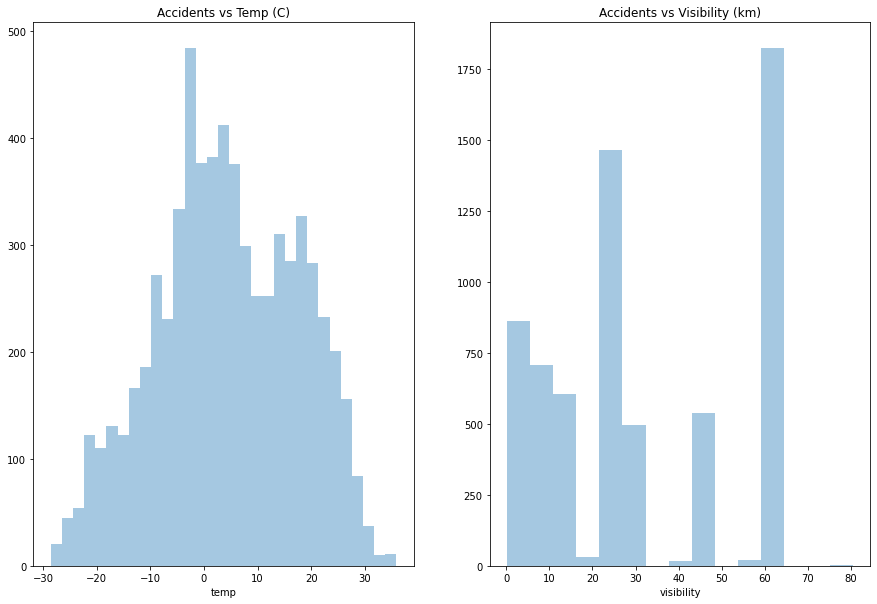

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

f, axes = plt.subplots(1, 2,figsize=(15,10))
#Temp
axes[0].set_title('Accidents vs Temp (C)')
ha_dist = sns.distplot(data_traffic_accidents['temp'],
                       kde=False,
                       ax=axes[0])

#Visibility
axes[1].set_title('Accidents vs Visibility (km)')
ha_dist = sns.distplot(data_traffic_accidents['visibility'],
                       kde=False,
                       label='heart-attack',
                       ax=axes[1])


### Heatmaps

In [14]:
# Heatmap of Accidents:
acc_heatmap = folium.Map(location=[51.0447, -114.0719], zoom_start=10)
acc_data = [[row['latitude'],row['longitude']] for index, row in data_traffic_accidents.iterrows()]
HeatMap(acc_data).add_to(acc_heatmap)
acc_heatmap.save('Full_Accident_Heatmap.html')

# Add traffic signal markers
signal_cds = [[row['latitude'],row['longitude']] for index, row in data_traffic_signals.iterrows()]
for cds in range(len(signal_cds)):
    folium.Marker(signal_cds[cds]).add_to(acc_heatmap)
acc_heatmap.save('Full_Accident_Heatmap(signals).html')

# Hide accidents that appear within 100m of a signal
no_signal_acc = []
for i in range(len(data_traffic_accidents)):
    # Generate location of the current accident
    accident_loc = [data_traffic_accidents['latitude'][i],data_traffic_accidents['longitude'][i]]
    plot = True
    # Check the accident location against all signal locations
    for cds in range(len(signal_cds)):
        # Find the distance between the accident and the current signal location
        lon_dif = accident_loc[1]-signal_cds[cds][1]
        lat_dif = accident_loc[0]-signal_cds[cds][0]
        lon_dif_meters = lon_dif*69000
        lat_dif_meters = lat_dif*111000
        distance = (lon_dif_meters**2+lat_dif_meters**2)**0.5
        # Accident is within 100m of a signal, break and check the next signal
        if distance<100:
            plot = False
            break
    # Accident was not found to be within range of a signal, 
    # add it to the list of accidents to plot
    if plot==True:
        no_signal_acc.append(accident_loc)
        
# Generate map for the accidents that occur outside of a signal
no_signal_map = folium.Map(location = [51.0447, -114.0719], zoom_start = 10)
HeatMap(no_signal_acc).add_to(no_signal_map)
no_signal_map.save('Filtered_Accident_HM.html')

signal_cds = [[row['latitude'],row['longitude']] for index, row in data_traffic_signals.iterrows()]
signal_map = no_signal_map
for cds in range(len(signal_cds)):
    folium.Marker(signal_cds[cds]).add_to(signal_map)
signal_map.save('Filtered_Accident_HM(signals).html')

## Visualizing Speed Limits

In [15]:
# Create the map
map_speed_limits = folium.Map(location=[51.0447, -114.0719], zoom_start=10)

# Go through every road
for index, row in data_speed_limit.iterrows():
    # Get coordinates for the road
    coordinates = row['coordinates']
    for line in coordinates:
        # Don't do anything if list is empty
        if not line:
            continue
        # Get color intensity based on speed limit
        color = '#%02x%02x%02x' % (200, int(max((110-row['SPEED']) * 255 / 110, 0)), int(max((110-row['SPEED']) * 255 / 110, 0)))
        # Add line to the map
        folium.PolyLine(locations=line,weight=3, color=color).add_to(map_speed_limits)
        

# Save map
map_speed_limits.save('map_speed_limits.html')
map_speed_limits

## Visualizing Traffic Heat Map

In [16]:
# Do a heat map of the traffic volume